# Hessian Riemannian method

In [1]:
import numpy
import autograd.numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt
from autograd import grad
from scipy.optimize import minimize
import time
import math
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

In [2]:
 def inv_A(Hf,B,x):
    # H is the hession matrix of dimension n x n
    # Bx=b is the linear equality constraint, B is of dimension m x n
    
    H_inv = np.linalg.inv(Hf(x))
    if B is None:
        return H_inv
    
    n = B.shape[1]
    C1 = B @ H_inv @ B.T
    C2 = np.linalg.inv(C1)
    C3 = B.T @ C2 @ B @ H_inv
    P = np.identity(n) - C3
    return H_inv @ P

In [3]:
def ngd(x, r, func, Hf, B, p):
    eta = p['eta']
    f, df = func(x)
    
    _A = inv_A(Hf,B,x)
    ndf = _A.dot(df)
    _x = x - eta*ndf
        
    _f, _df = func(_x)
    return _f, _df, _x, r

def aeng(x, r, func, Hf, B, p):
    # H is a function of x
    # B is a constant matrix
    eta = p['eta']
    c = p['c']
    
    f, df = func(x)
    dg = df / (2*np.sqrt(f+c))
    
    _A = inv_A(Hf,B,x)
    ndg = _A.dot(dg)
    _r = r / (1+2*eta*ndg*ndg)
    _x = x - 2 * eta * _r * ndg
        
    _f, _df = func(_x)
    return _f, _df, _x, _r

In [4]:
def runner(x0, func, Hf, B, optim, minf, p):
    t = time.time()

    r0 = np.sqrt(func(x0)[0]+1) * np.ones_like(x0) / p['lambda1']
    res = dict(fs=[func(x0)[0]], dfs=[func(x0)[1]], xs=[x0], rs=[r0])
    fs, dfs, xs, rs = res['fs'], res['dfs'], res['xs'], res['rs']
    
    k = 1
    
    print('[{:4}], f: {:.4e}, x:{}'.format(0, fs[-1], 1, xs[-1]))
    
    while k > 0 and abs(fs[-1]-minf) > p['tol'] and k < p['maxiter']:
        f, df, x, r = optim(xs[-1], rs[-1], func, Hf, B, p)
        fs.append(f)
        dfs.append(df)
        xs.append(x)
        rs.append(r)

        if k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, x:{}, r:{}'.format(k, f, x, r))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k-1))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1]))
        
    return res

# 1. Quadratic function
$$\min f(x)=(x_1-1)^2+\alpha(x_2-1)^2$$
$$(x_1+0.5)^2+(x_2-1)^2<1$$
The minimum value of $f$ is 0.25 at minimizer $(0.5,1)$.

In [5]:
def quad(x):
    c = [1, 1]
    return (x[0]-c[0])**2 + alpha * (x[1]-c[1])**2 

def quad_dfun(x):
    grad = np.zeros(len(x))
    grad[0] = 2 * (x[0]-1)
    grad[1] = 2 * alpha * (x[1]-1)
    return grad

def quad_func(x):
    return quad(x), quad_dfun(x)

In [6]:
def Hfqc(x):
    c, rd = [-0.5, 1], 1
    u = rd -(x[0]-c[0])**2-(x[1]-c[1])**2
    hxx = -2*np.log(u) + 4*(x[0]-c[0])**2/u
    hxy = 4*(x[0]-c[0])*(x[1]-c[1])/u
    hyy = -2*np.log(u) + 4*(x[1]-c[1])**2/u
    return np.array([[hxx,hxy],[hxy,hyy]]) # x1^2+x2^2<2

In [7]:
alpha = 10
xq = np.array([-1., 1.8])
Bq = None
minf = 0.25

In [8]:
quad_ngd = runner(xq, quad_func, Hfqc, Bq, ngd, minf,
                 p=dict(eta=8e-3, c=1, lambda1=1, maxiter=50000, tol=1e-6, gap=2000))

[   0], f: 1.0400e+01, x:1
[2000], f: 2.5011e-01, x:[0.4999 1.    ], r:[3.3764 3.3764]
------------------
iterations: 3175
solution time: 0.2022s
current function value: 0.2500009963328661
current parameter value: [0.5 1. ]


In [9]:
quad_aeng = runner(xq, quad_func, Hfqc, Bq, aeng, minf,
                 p=dict(eta=2e-1, c=1, lambda1=1, maxiter=50000, tol=1e-6, gap=1000))

[   0], f: 1.0400e+01, x:1
------------------
iterations: 47
solution time: 0.0072s
current function value: 0.25000087260126497
current parameter value: [0.5 1. ]


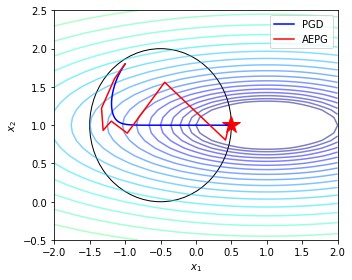

In [10]:
xg, yg = [z[0] for z in quad_ngd['xs']], [z[1] for z in quad_ngd['xs']]
xe, ye = [z[0] for z in quad_aeng['xs']], [z[1] for z in quad_aeng['xs']]

xmin, xmax, xstep = -2, 2, .1
ymin, ymax, ystep = -0.5, 2.5, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))
z = quad([x, y])
minima = np.array([0.5, 1])
minima_ = minima.reshape(-1, 1)


fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(x, y, z, levels=np.logspace(0, 3, 35), norm=LogNorm(),
               alpha=0.5, cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)
ell = Ellipse(xy=(-0.5,1), width=2, height=2, linewidth=1, fill=False)
ax.add_patch(ell)
ax.plot(xg, yg, color='b', label='PGD') 
ax.plot(xe, ye, color='r', label='AEPG') 
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.legend()
plt.tight_layout()
# plt.savefig('plots/aeng_quad10_path.png', dpi=300)

# 2. Rosenbrock function
$$\min_x f(x_1, x_2) = (1-x_1)^2+100(x_2-x_1^2)^2$$
$$x_1<0, x_2>0$$
The minimum value of $f$ is 1 at minimizer $(0, 0)$.

In [11]:
def rosen_fun(x):
    return (1-x[0])**2+alpha*(x[1]-x[0]**2)**2

def rosen_dfun(x):
    grad = np.zeros(len(x))
    grad[0] = -4*alpha*(x[1]-x[0]**2)*x[0]-2*(1-x[0])
    grad[1] = 2*alpha*(x[1]-x[0]**2)
    return grad

def rosen_func(x):
    return rosen_fun(x), rosen_dfun(x)

In [12]:
def Hfrl(x):
    return np.array([[-1/x[0],0],[0,1/x[1]]]) # x1<0, x2>0

In [13]:
alpha = 100
xr = np.array([-0.5, 2])
Br = None
minf = 1

In [14]:
rosen_ngd = runner(xr, rosen_func, Hfrl, Br, ngd, minf,
                   p=dict(eta=2e-3, c=1, lambda1=1, maxiter=1000000, tol=1e-5, gap=10000))

[   0], f: 3.0850e+02, x:1
------------------
iterations: 8712
solution time: 0.4778s
current function value: 1.000009998386112
current parameter value: [-1.9438e-15  3.1620e-04]


In [15]:
rosen_aeng = runner(xr, rosen_func, Hfrl, Br, aeng, minf, 
                   p=dict(eta=1e-4, c=1, lambda1=0.1, maxiter=50000, tol=1e-5, gap=2000))

[   0], f: 3.0850e+02, x:1
------------------
iterations: 1656
solution time: 0.1187s
current function value: 1.0000099893054688
current parameter value: [-3.1301e-15  3.1606e-04]


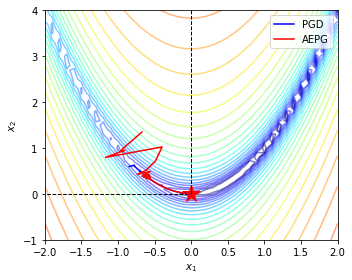

In [16]:
xg, yg = [z[0] for z in rosen_ngd['xs']], [z[1] for z in rosen_ngd['xs']]
xe, ye = [z[0] for z in rosen_aeng['xs']], [z[1] for z in rosen_aeng['xs']]

xmin, xmax, xstep = -2, 2, .1
ymin, ymax, ystep = -1, 4, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))
z = rosen_fun([x, y])
minima = np.array([0, 0])
minima_ = minima.reshape(-1, 1)

t = np.linspace(-4, 4, 100)

fig, ax = plt.subplots(figsize=(5, 4))
CS = ax.contour(x, y, z, levels=np.logspace(0, 4, 25), norm=LogNorm(),
           alpha=0.5, cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)
ax.hlines(0, -4, 0, 'k', lw=1, linestyle='--')
ax.vlines(0, 0, 10, 'k', lw=1, linestyle='--')
ax.plot(xg[1:], yg[1:], color='b', label='PGD')
ax.plot(xe[1:], ye[1:], color='r', label='AEPG')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.legend(loc='best')
plt.tight_layout()